In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
# features
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge, LinearRegression
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import shuffle

#calibration library
from crepes import WrapRegressor

# metrics
from sklearn.metrics import roc_auc_score
from sklearn import tree
from scipy.special import comb

import models as md
import utils as ut
import calibrator as cal

%load_ext autoreload 
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
sepsis_survival_minimal_clinical_records = fetch_ucirepo(id=827) 
  
# data (as pandas dataframes) 
X = sepsis_survival_minimal_clinical_records.data.features 
y = sepsis_survival_minimal_clinical_records.data.targets 

In [3]:
def create_balanced_subsample(X, y):
    """
    Create a balanced subsample by randomly undersampling the majority class.
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        The feature matrix
    y : array-like of shape (n_samples,)
        The target vector with binary values (0 and 1)
    
    Returns:
    --------
    X_balanced : array-like
        The balanced feature matrix
    y_balanced : array-like
        The balanced target vector
    """
    # Get indices for each class
    alive_indices = np.where(y == 1)[0]
    dead_indices = np.where(y == 0)[0]
    
    # Get the size of the minority class
    n_minority = len(dead_indices)
    
    # Randomly sample from majority class
    alive_indices_subsampled = np.random.choice(
        alive_indices, 
        size=n_minority, 
        replace=False
    )
    
    # Combine indices
    balanced_indices = np.concatenate([alive_indices_subsampled, dead_indices])
    
    # Shuffle the combined indices
    balanced_indices = shuffle(balanced_indices)
    
    # Create balanced datasets
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]
    
    print("Original class distribution:")
    print(f"Class 1 (alive): {len(alive_indices)}")
    print(f"Class 0 (dead): {len(dead_indices)}")
    print("\nBalanced class distribution:")
    print(f"Class 1 (alive): {sum(y_balanced == 1)}")
    print(f"Class 0 (dead): {sum(y_balanced == 0)}")
    
    return X_balanced, y_balanced

# Usage:
#X_balanced, y_balanced = X.values, y.values.flatten()
X_balanced, y_balanced = create_balanced_subsample(X.values, y.values.flatten())
y_balanced = 1-y_balanced

Original class distribution:
Class 1 (alive): 102212
Class 0 (dead): 8129

Balanced class distribution:
Class 1 (alive): 8129
Class 0 (dead): 8129


In [4]:
clf_list = ['GB', 'KNN', 'RF', 'XGB', 'LR']
training_results = [] 
num_runs = 5
binary_clfs = {} 
calibrators = {} 
bins = 10 
results_df = pd.DataFrame() 

for i in range(num_runs): 
        X_train, X_test, y_train, y_test = train_test_split(
            X_balanced, y_balanced, test_size=0.20, random_state=i)

        X_train, X_valid, y_train, y_valid = train_test_split(
                X_train, y_train, test_size=0.20, random_state=i)

        for name in clf_list: 
            curr_clf = md.model_choice(name, X_train, y_train)
            curr_clf.fit(X_train, y_train)
            probs = curr_clf.predict_proba(X_test)[:, 1]
            _, _, ece_l1, ece_l2, _ = ut.expected_calibration_error(prob_true=np.asarray(y_test), 
                                                                 prob_pred=np.asarray(probs), 
                                                                 num_bins=bins)
            training_results.append({
                'clf': name, 
                'run': i, 
                'ece_l1': ece_l1, 
                'ece_l2': ece_l2, 
                'accuracy': curr_clf.score(X_test, y_test), 
                'auc': roc_auc_score(y_test, probs),
                'calibrated': False
            })
            binary_clfs[name] = curr_clf

            calibrator = cal.BinningCalibrator(bins=bins)
            calibrator.calibrate(curr_clf.predict_proba(X_valid)[:, 1], y_valid)
            y_cal_probs = calibrator.transform(probs)
            _, _, ece_l1, ece_l2, _ = ut.expected_calibration_error(prob_true=np.asarray(y_test),
                                                                 prob_pred=np.asarray(y_cal_probs),
                                                                 num_bins=bins)
            training_results.append({
                'clf': name, 
                'run': i, 
                'ece_l1': ece_l1, 
                'ece_l2': ece_l2, 
                'accuracy': ((y_cal_probs > 0.5) ==  y_test).mean(), 
                'auc': roc_auc_score(y_test, y_cal_probs),
                'calibrated': True
            })
            calibrators[name] = calibrator

running model search
running model search
running model search
running model search
running model search


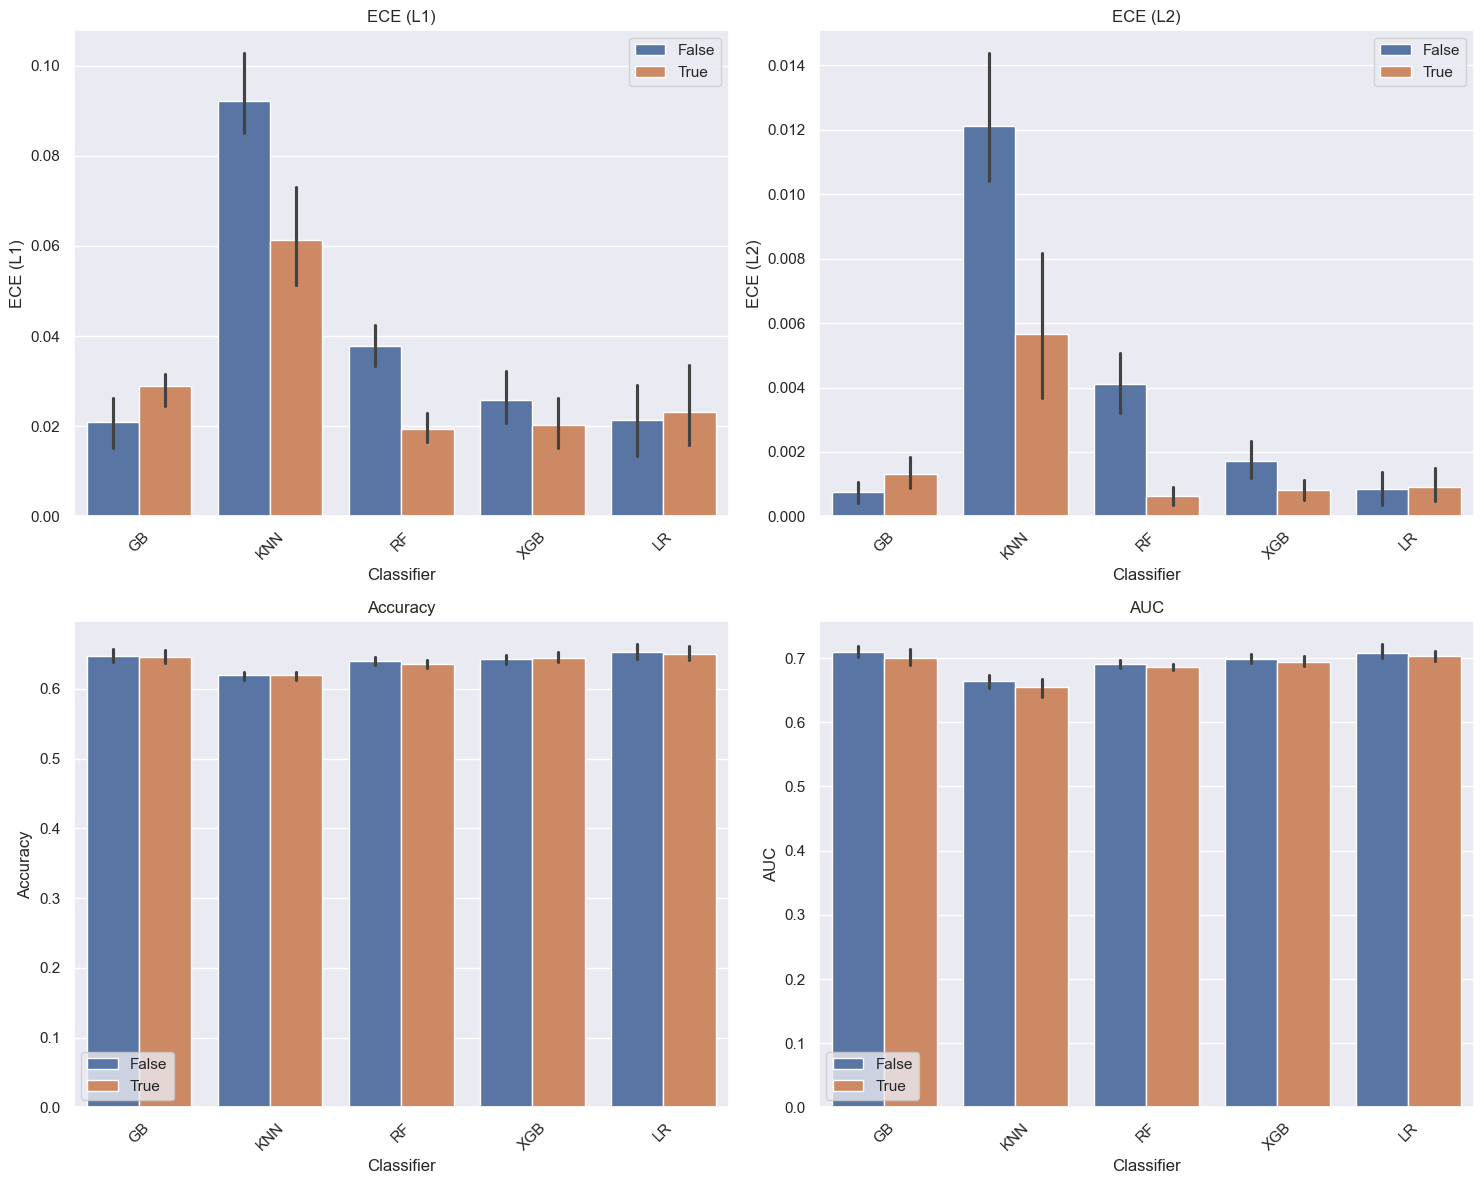

In [5]:
training_results_df = pd.DataFrame(training_results)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['ece_l1', 'ece_l2', 'accuracy', 'auc']
titles = ['ECE (L1)', 'ECE (L2)', 'Accuracy', 'AUC']
axes = axes.ravel()

# Create subplots
for idx, (metric, title) in enumerate(zip(metrics, titles)):
    sns.barplot(
        data=training_results_df,
        x='clf',
        y=metric,
        hue='calibrated',
        ax=axes[idx],
    )
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Classifier')
    axes[idx].set_ylabel(title)
    # Rotate x-axis labels for better readability
    axes[idx].tick_params(axis='x', rotation=45)
    # Move legend to a better position
    axes[idx].legend(title='')

# Adjust layout
plt.tight_layout()
plt.show()

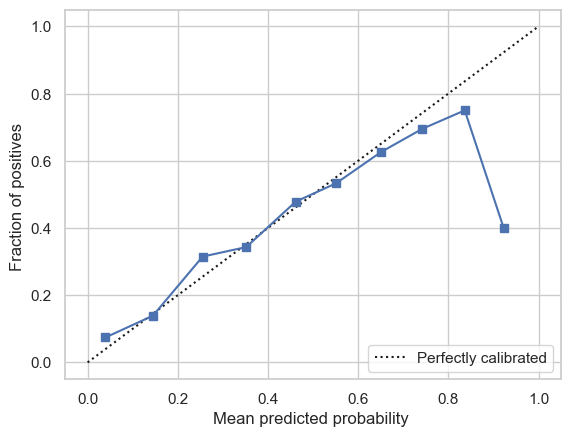

In [227]:
name = 'XGB'
curr_clf = md.model_choice(name, X_train, y_train)
curr_clf.fit(X_train, y_train)

from sklearn.calibration import calibration_curve, CalibrationDisplay
y_prob = curr_clf.predict_proba(X_valid)[:, 1]
prob_true, prob_pred = calibration_curve(y_valid, y_prob, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot()

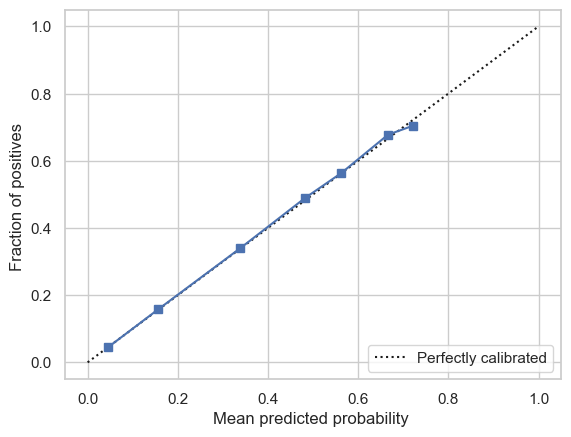

In [228]:
y_prob = curr_clf.predict_proba(X_valid)[:, 1]
calibrator = cal.HistogramCalibrator()
calibrator.calibrate(y_prob=y_prob, 
                     y_true=y_valid)
cal_valid_probs = calibrator.transform(y_prob)
        
prob_true, prob_pred = calibration_curve(y_valid, cal_valid_probs, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, cal_valid_probs)
disp.plot()

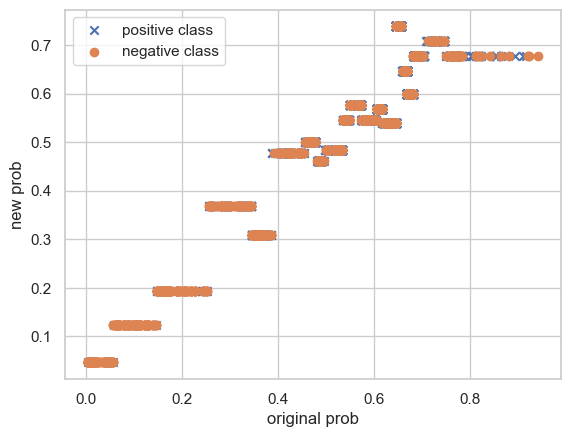

In [229]:
mask = y_valid ==1 
plt.scatter(y_prob[mask], cal_valid_probs[mask], marker='x', label='positive class')
plt.scatter(y_prob[~mask], cal_valid_probs[~mask], marker='o', label='negative class')
plt.xlabel("original prob")
plt.ylabel("new prob")
plt.legend()

In [230]:
alpha = 0.1

results = [] 
grid_params = np.linspace(0.1, 0.9, 9)
n = 100
num_iter = 20
for alpha in [0.1, 0.3, 0.5]:  
    for i in range(num_iter): 
        ind = np.random.choice(len(X_test), n, replace=False)

        const = comb(n, 2, exact=True)
        X_test_sample = X_test[ind]
        y_test_sample = y_test[ind]
        
        # two bin calibration 
        train_binary_pred = curr_clf.predict(X_train)
        pos_mask = train_binary_pred == 1
        pos_val = y_train[pos_mask].mean() 
        
        neg_mask = train_binary_pred == 0
        neg_val = y_train[neg_mask].mean() 
        value_map = {0:neg_val , 1:pos_val}
        
        binary_pred = curr_clf.predict(X_test_sample)
        binary_probs = np.vectorize(value_map.get)(binary_pred)
        binary_order = np.argsort(binary_probs)[::-1]
        binary_probs = binary_probs[binary_order]


        cal_probs = calibrator.transform(curr_clf.predict_proba(X_test_sample)[:, 1])
        cal_order = np.argsort(cal_probs)[::-1]
        cal_probs = cal_probs[cal_order]
        #print(np.unique(cal_probs, return_counts=True))

        i = 0
        for j in range(i+1, len(grid_params-1)):
            w0 = grid_params[i]
            w1 = grid_params[j]
            #print(w0, w1)
            beta = alpha/(1-alpha) * (w1)/(w1-w0)

            cal_pred = cal_probs > beta
            #print(w1/w0, beta, cal_pred.mean())
            cal_true = y_test_sample[cal_order]
            
            binary_pred = binary_probs > beta
            binary_true = y_test_sample[binary_order]

            X_bin, Y_bin, Z_bin = get_performance_stats(predicted_priority=binary_pred, 
                                                        true_priority=binary_true)
            X_cal, Y_cal, Z_cal = get_performance_stats(predicted_priority=cal_pred,
                                                        true_priority=cal_true)

            results.append(
                {'w0': w0, 
                'w1': w1, 
                'w1/w0 ratio': w1/w0,
                'alpha': alpha,  
                'L': X_cal/const, 
                'N': Z_cal/const,
                'L+N':  X_cal/const + Z_cal/const,
                'beta': beta,
                 r'$\theta$': alpha,
                'CR': get_CR(alpha=alpha, w0=w0, w1=w1, X=X_cal/const, Y=Y_cal/const, Z=Z_cal/const), 
                 'seed': i, 
                'Predictor': 'Calibrated'}
            )

            results.append(
                {'w0': w0, 
                'w1': w1, 
                'w1/w0 ratio': w1/w0,
                'alpha': alpha,  
                'L': X_bin/const, 
                'N': Z_bin/const,
                'L+N':  X_bin/const + Z_bin/const,
                'beta': beta,
                 r'$\theta$': alpha, 
                'seed': i,
                'CR': get_CR(alpha=alpha, w0=w0, w1=w1, X=X_bin/const, Y=Y_bin/const, Z=Z_bin/const), 
                'Predictor': 'Binary'}
            )


In [231]:
results_df = pd.DataFrame(results)

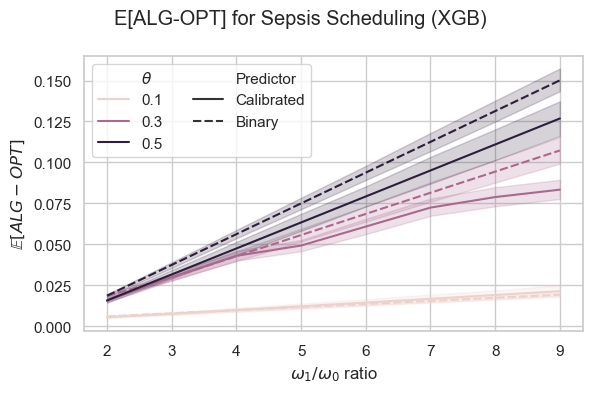

In [232]:
sns.set_style("whitegrid")
plt.figure(figsize=(6, 4)) 
sns.lineplot(data=results_df, x='w1/w0 ratio', y='CR', style='Predictor', hue=r'$\theta$')#.set_title("L(f(X), Y)")
plt.ylabel(r"$\mathbb{E}[ALG-OPT]$")
plt.xlabel(r"$\omega_1/\omega_0$ ratio")
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig(f"img/hist_sepsis_{name}_notitle.pdf")
plt.suptitle(f"E[ALG-OPT] for Sepsis Scheduling ({name})")
plt.tight_layout()
plt.savefig(f"img/hist_sepsis_{name}.pdf")

Text(0.5, 0.98, 'Expected Number of Inversion between Calibrated and Binary Predictor Advice (alpha=0.3)')

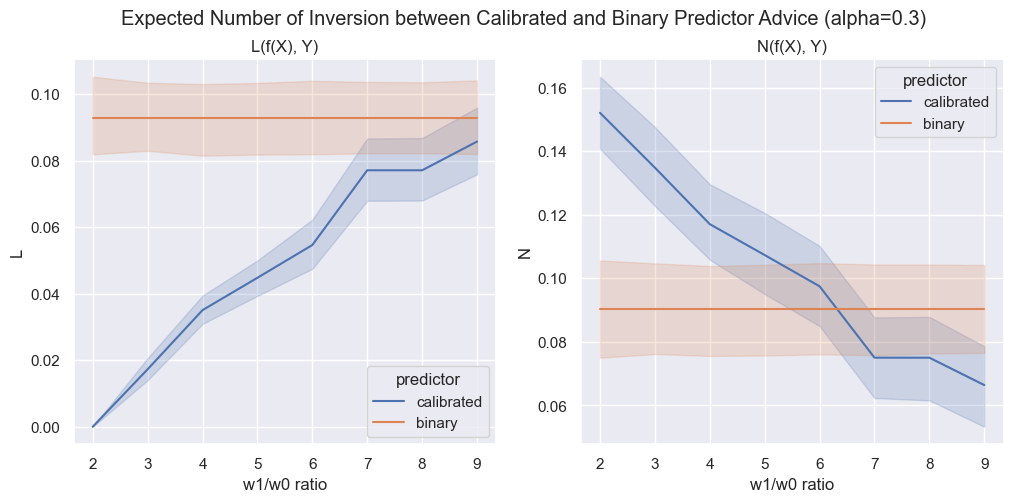

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes= axes.flatten() 
sns.lineplot(data=results_df, x='w1/w0 ratio', y='L', hue='predictor', ax=axes[0]).set_title("L(f(X), Y)")
sns.lineplot(data=results_df, x='w1/w0 ratio', y='N', hue='predictor', ax=axes[1]).set_title("N(f(X), Y)")
plt.suptitle(f"Expected Number of Inversion between Calibrated and Binary Predictor Advice (alpha={alpha})")

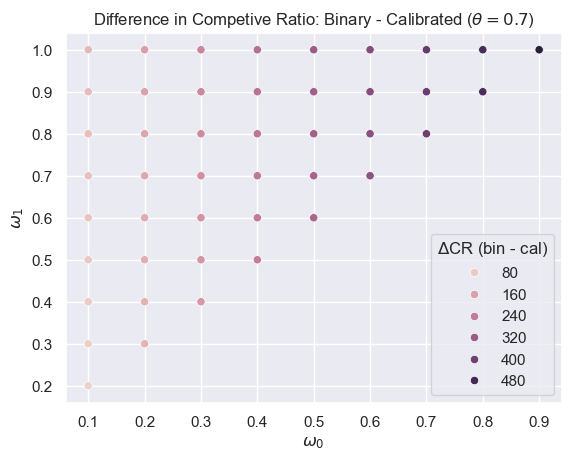

In [281]:
sns.scatterplot(data=results_df, x='w0', y='w1', hue=r'$\Delta$CR (bin - cal)')
plt.ylabel(r"$\omega_1$")
plt.xlabel(r"$\omega_0$")
plt.title(r"Difference in Competive Ratio: Binary - Calibrated ($\theta=" + str(alpha) + "$)")
plt.savefig(f"img/scheduling{alpha}.pdf")

In [10]:
def get_CR(alpha:float, 
           w0: float, 
           w1: float,
           X: int, 
           Y: int, 
           Z: int) -> float: 
    return alpha*w1*X + alpha*w0*Y + (w1-w0)*Z
    
def get_performance_stats(predicted_priority: np.ndarray,
                          true_priority: np.ndarray) -> (int, int, int):
    # needs to be ordered 
    mask = predicted_priority== 1 
    high_pred_label = true_priority[mask]
    #Number of inversions of high and low priority jobs among jobs predicted to be high priority.
    X, Y, Z = 0, 0, 0
    for i in range(len(high_pred_label)): 
        for j in range(i+1, len(high_pred_label)): 
            if high_pred_label[i] == 0: 
                if high_pred_label[j] == 1: 
                    X+=1 
                elif high_pred_label[j] == 0:
                    Y+=1
    # can be 1 loop but this is more readable
    for i in range(len(true_priority)): 
        for j in range(i+1, len(true_priority)): 
            if true_priority[i] == 0 and true_priority[j] == 1: 
                Z+=1 
    Z = Z - X 
    return X, Y, Z